## RANSAC Testing

image coregistration / transformation for aspect refinement 

https://scikit-image.org/docs/stable/auto_examples/transform/plot_matching.html#sphx-glr-auto-examples-transform-plot-matching-py

In [107]:
import numpy as np
from matplotlib import pyplot as plt 

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac

import fitsio
from astropy.io import fits
import numpy.ma as ma
import pandas as pd

In [17]:
# generate synthetic checkerboard image and add gradient for the later matching
# checkerboard = img_as_float(data.checkerboard())
# img_orig = np.zeros(list(checkerboard.shape) + [3])
# img_orig[..., 0] = checkerboard
# gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
#                                0:img_orig.shape[1]]
#                       / float(img_orig.shape[0]))
# img_orig[..., 1] = gradient_r
# img_orig[..., 2] = gradient_c
# img_orig = rescale_intensity(img_orig)
# img_orig_gray = rgb2gray(img_orig)

# # warp synthetic image
# tform = AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
# img_warped = warp(img_orig, tform.inverse, output_shape=(200, 200))
# img_warped_gray = rgb2gray(img_warped)

img_orig_1 = fits.open('/home/bekah/glcat/astrometry/e21442/dose_files/e21442-nd-t0002-b00-f00007-g_dose.fits')
img_warped_2 = fits.open('/home/bekah/glcat/astrometry/e21442/dose_files/e21442-nd-t0002-b00-f00008-g_dose.fits')

img_orig_gray = img_orig_1[0].data
img_warped_gray = img_warped_2[0].data

# extract corners using Harris' corner measure
coords_orig = corner_peaks(corner_harris(img_orig_gray), threshold_rel=0.001,
                           min_distance=5)
coords_warped = corner_peaks(corner_harris(img_warped_gray),
                             threshold_rel=0.001, min_distance=5)

# determine sub-pixel corner position
coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=9)
coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped,
                                     window_size=9)


def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r, c = np.round(coord).astype(np.intp)
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = (inliers == False)


# compare "true" and estimated transform parameters
print("Ground truth:")
print(f'Scale: ({tform.scale[1]:.4f}, {tform.scale[0]:.4f}), '
      f'Translation: ({tform.translation[1]:.4f}, '
      f'{tform.translation[0]:.4f}), '
      f'Rotation: {-tform.rotation:.4f}')
print("Affine transform:")
print(f'Scale: ({model.scale[0]:.4f}, {model.scale[1]:.4f}), '
      f'Translation: ({model.translation[0]:.4f}, '
      f'{model.translation[1]:.4f}), '
      f'Rotation: {model.rotation:.4f}')
print("RANSAC:")
print(f'Scale: ({model_robust.scale[0]:.4f}, {model_robust.scale[1]:.4f}), '
      f'Translation: ({model_robust.translation[0]:.4f}, '
      f'{model_robust.translation[1]:.4f}), '
      f'Rotation: {model_robust.rotation:.4f}')

# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences')

plt.show()

ValueError: operands could not be broadcast together with shapes (11,11,3) (0,0,3) 

## Rigid Transform 3 points 
http://nghiaho.com/?page_id=671
https://github.com/nghiaho12/rigid_transform_3D

In [195]:
# need to plot xylist for multiple frames to see if it's likely the points can match 

from astropy.table import Table
f17 = fits.open('/home/bekah/gphoton_working/test_data/e09869/frame17_1s_e09869.xyls')

f172 = fits.open('/home/bekah/gphoton_working/test_data/e09869/frame172_1s_e09869.xyls')
f173 = fits.open('/home/bekah/gphoton_working/test_data/e09869/frame173_1s_e09869.xyls')
f174 = fits.open('/home/bekah/gphoton_working/test_data/e09869/frame174_1s_e09869.xyls')
f175 = fits.open('/home/bekah/gphoton_working/test_data/e09869/frame174_1s_e09869.xyls')
f176 = fits.open('/home/bekah/gphoton_working/test_data/e09869/frame174_1s_e09869.xyls')


table = Table.read(f17)
t17 = table.to_pandas()

table = Table.read(f172)
t172 = table.to_pandas()
table = Table.read(f173)
t173 = table.to_pandas()
table = Table.read(f174)
t174 = table.to_pandas()
table = Table.read(f175)
t175 = table.to_pandas()
table = Table.read(f176)
t176 = table.to_pandas()

<IPython.core.display.Javascript object>


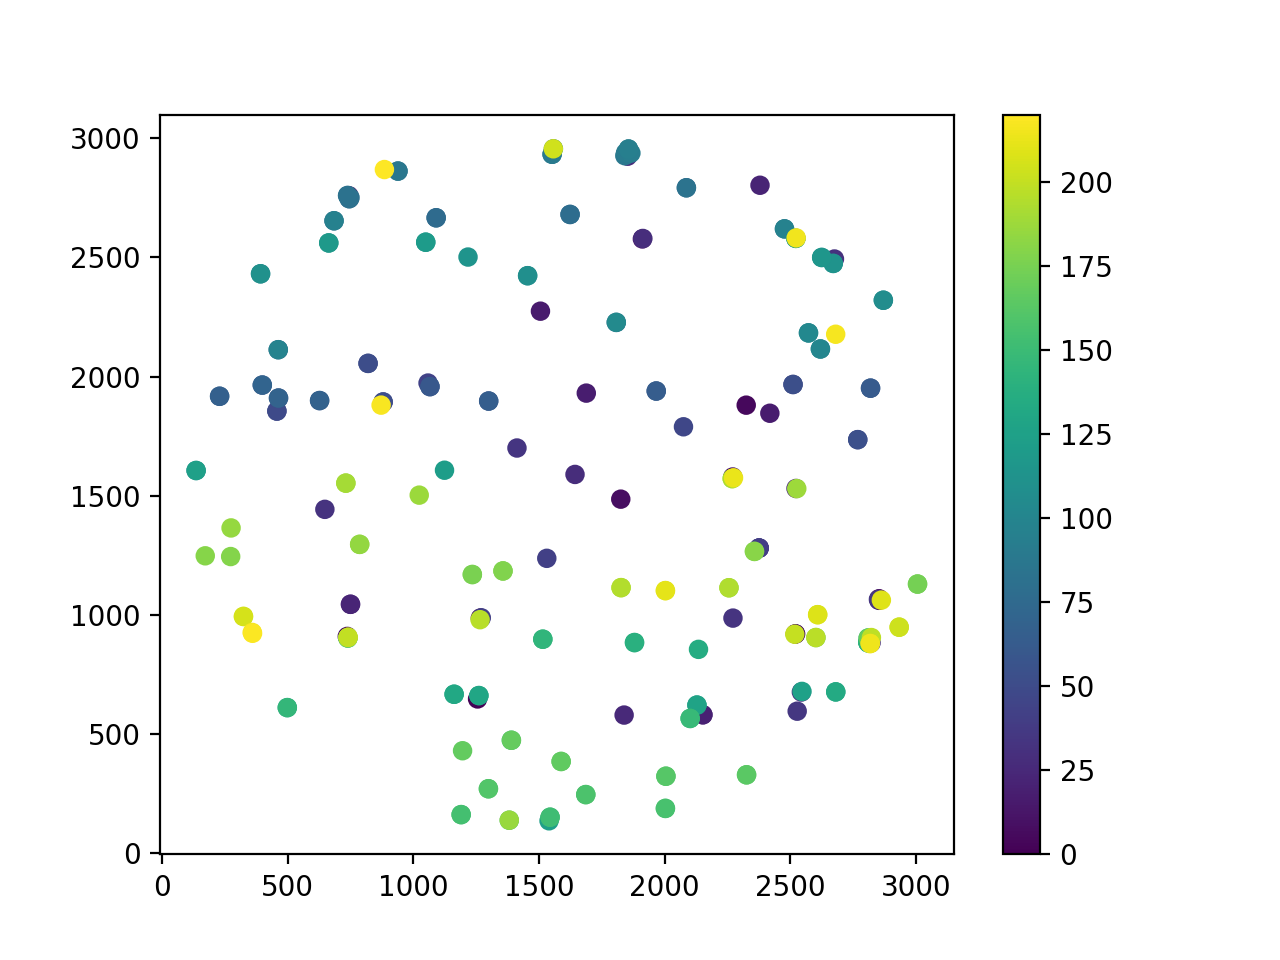

In [193]:
#plt.scatter(t176['X'],t176['Y'])
plt.scatter(t175['X'],t175['Y'],c=t175.index, cmap='viridis')
plt.colorbar()

<IPython.core.display.Javascript object>


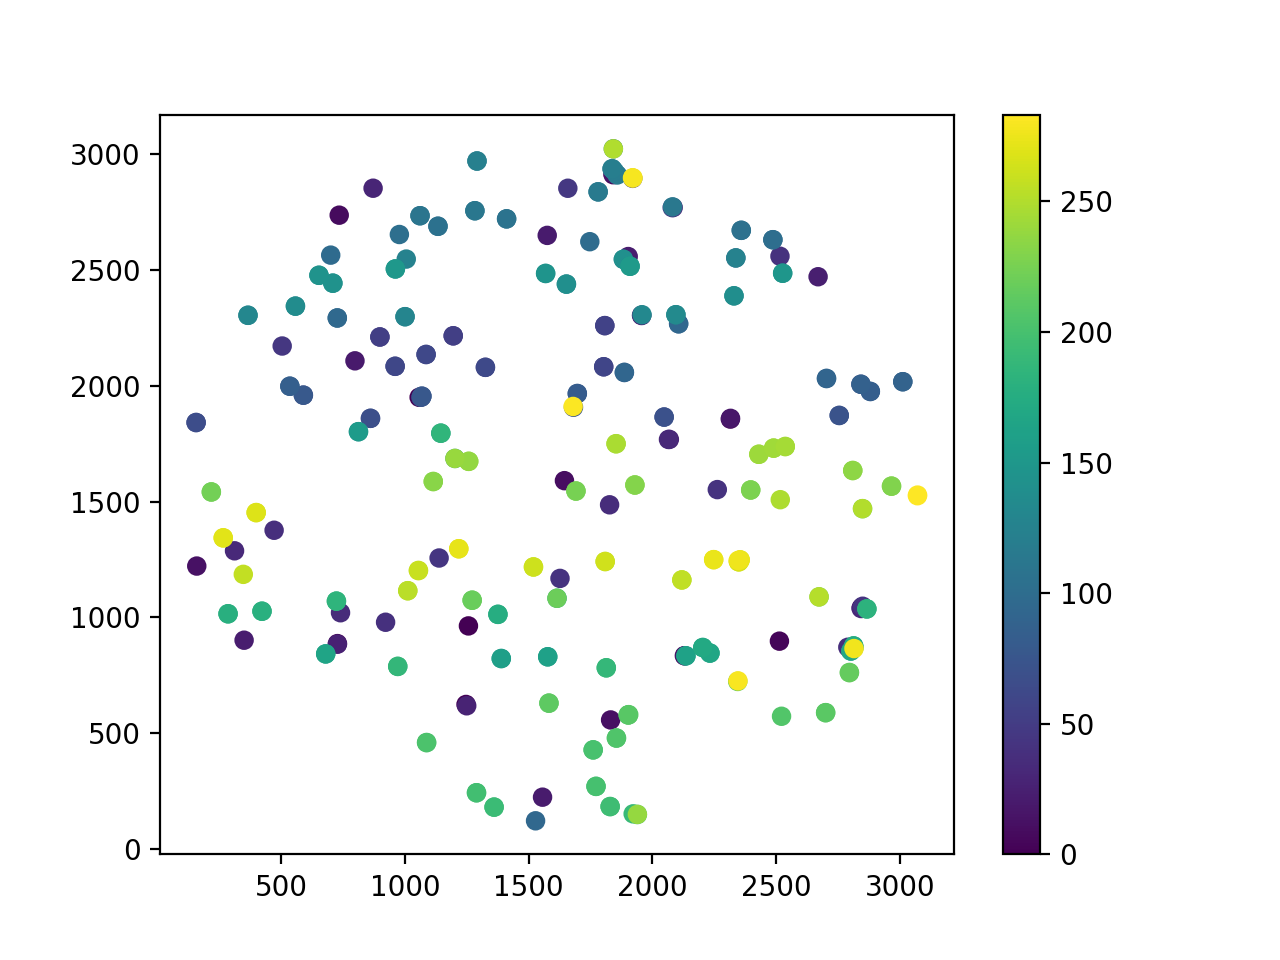

In [196]:
#plt.scatter(t176['X'],t176['Y'])
plt.scatter(t17['X'],t17['Y'],c=t17.index, cmap='viridis')
plt.colorbar()

<IPython.core.display.Javascript object>


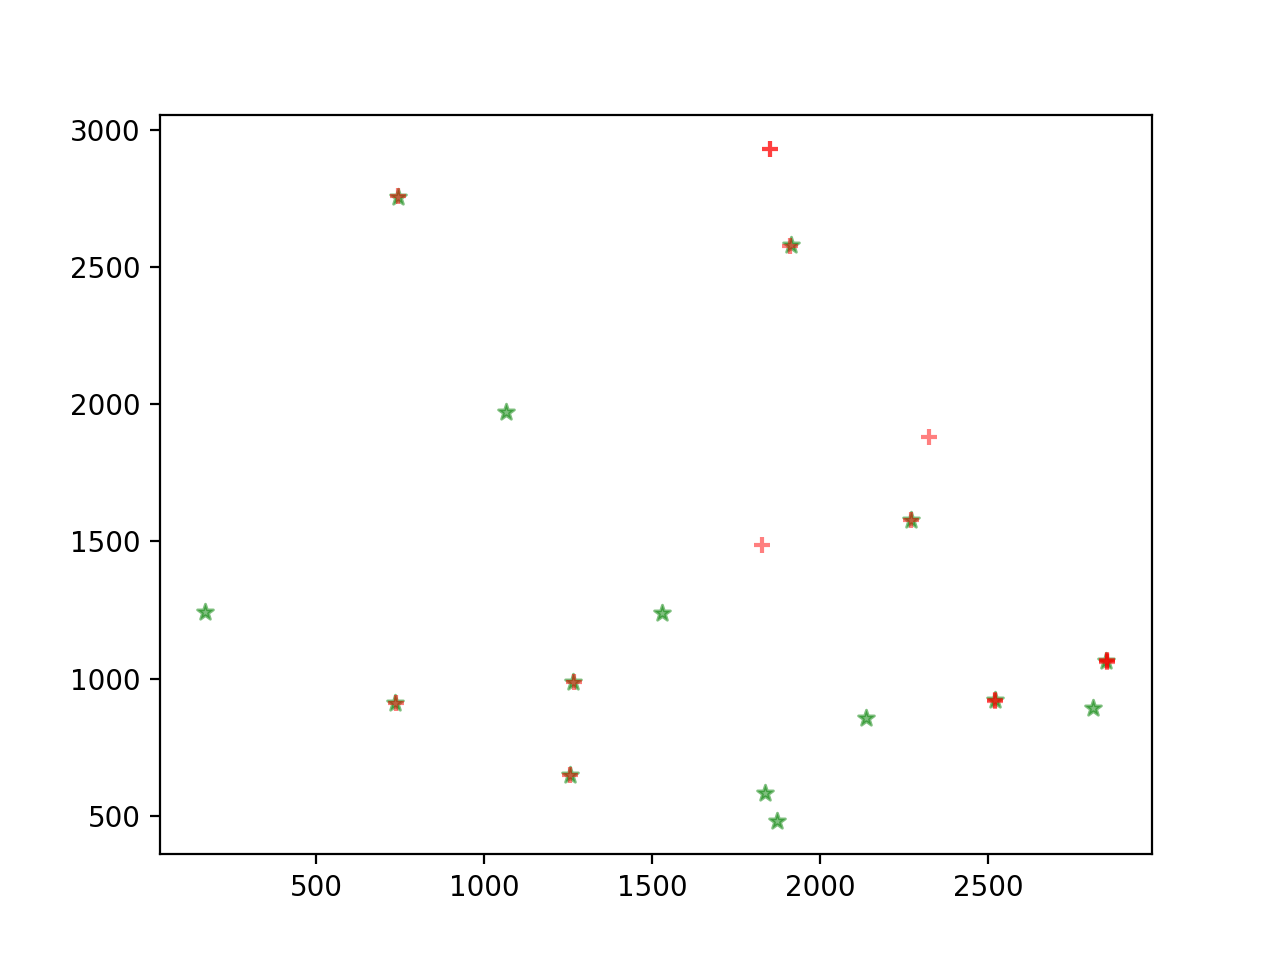

In [206]:
%matplotlib notebook

how_many = 15
#plt.scatter(t172['X'][0:how_many],t172['Y'][0:how_many],c='orange',alpha=.5)
plt.scatter(t173['X'][0:how_many],t173['Y'][0:how_many],marker='*',c='green',alpha=.5)
plt.scatter(t174['X'][0:how_many],t174['Y'][0:how_many],marker='+',c='red',alpha=.5)
#plt.scatter(t175['X'][0:how_many],t175['Y'][0:how_many],marker='.',c='blue',alpha=.5)
#plt.scatter(t176['X'][0:how_many],t176['Y'][0:how_many],marker='o',c='yellow',alpha=.5)

In [ ]:
# want a function to get rid of extra points that don't have matches in the corresponding frame 
for i in range(how_many): 
    t172['X'][i] = 
    t172['Y'][i] = 


In [64]:
print(t173[0:how_many])
print(t172[0:how_many])

             X            Y
0  1066.239014  1972.776733
1  1255.709351   647.757446
2  1265.345459   986.494202
3  2851.506104  1065.263794
4  2813.299316   892.565918
5  2137.131104   857.847290
6  2269.585938  1578.351562
7   736.333069   910.205627
8  1872.565918   481.388336
9  1837.592529   581.878967
             X            Y
0  1065.859741  1972.270020
1  2852.000000  1065.548950
2  1254.599731   646.890259
3  2812.102539   892.875916
4   736.418518   910.843750
5  2518.573242   919.337463
6  2135.859863   858.046265
7  1264.216187   987.398010
8  2269.359619  1578.436157
9  2322.793457  1879.406250


In [155]:
t173x = [1066.239014, 1255.709351, 2851.506104, 736.333069, 2269.585938]
t173y = [1972.776733, 647.757446, 1065.263794, 910.205627, 1578.351562]
print(type(t173x))
t172x = [1065.859741, 1254.599731, 2852.000000, 736.418518, 2269.359619]
t172y = [1972.270020, 646.890259, 1065.548950, 910.843750, 1578.436157]

t0 = [0, 0, 0, 0, 0]

A = np.array([t172x, t172y, t0])
B = np.array([t173x, t173y, t0])

<class 'list'>


In [198]:
how_many = 15

t176x = t176[0:how_many]['X'].values.tolist()
t176y = t176[0:how_many]['Y'].values.tolist()

t173x = t173[0:how_many]['X'].values.tolist()
t173y = t173[0:how_many]['Y'].values.tolist()

t172x = t172[0:how_many]['X'].values.tolist()
t172y = t172[0:how_many]['Y'].values.tolist()

t0 = np.full(how_many, 0).tolist()

A = np.array([t172x, t172y, t0])
#B = np.array([t173x, t173y, t0])
B = np.array([t176x, t176y, t0])

In [199]:
A

array([[1065.85974121, 2852.        , 1254.59973145, 2812.10253906,
         736.41851807, 2518.57324219, 2135.85986328, 1264.21618652,
        2269.35961914, 2322.79345703, 1850.01245117, 1825.75292969,
         745.71313477,  358.82666016, 1871.9864502 ],
       [1972.27001953, 1065.5489502 ,  646.89025879,  892.87591553,
         910.84375   ,  919.33746338,  858.04626465,  987.39801025,
        1578.43615723, 1879.40625   , 2936.34179688, 1486.0814209 ,
        1547.20788574,  925.91516113,  482.63952637],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ]])

In [165]:
# from:  https://github.com/nghiaho12/rigid_transform_3D/blob/master/rigid_transform_3D.py 

import numpy as np

# Input: expects 3xN matrix of points
# Returns R,t
# R = 3x3 rotation matrix
# t = 3x1 column vector

def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)
    
    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [200]:
import numpy as np
#from rigid_transform_3D import rigid_transform_3D

# Test with 272 and 273 

# Recover R and t
ret_R, ret_t = rigid_transform_3D(A, B)

# Compare the recovered R and t with the original
B2 = (ret_R@A) + ret_t

print("B2")
print(B2) 
print("")

# Find the root mean squared error
err = B2 - B
err = err * err
err = np.sum(err)
rmse = np.sqrt(err/n)

print("Points A")
print(A)
print("")

print("Points B")
print(B)
print("")

print("Ground truth rotation")
print(R)

print("Recovered rotation")
print(ret_R)
print("")

print("Ground truth translation")
print(t)

print("Recovered translation")
print(ret_t)
print("")

print("RMSE:", rmse)

if rmse < 1e-5:
    print("Everything looks good!")
else:
    print("Hmm something doesn't look right ...")

B2
[[2926.69196355 1166.890928   1728.04790062 1047.30315758 2239.33115786
  1235.5731123  1402.14976272 2003.04043668 1919.75735338 2137.33502887
  3275.97959191 2095.28547318 2758.17732204 2465.89634541 1242.61645466]
 [1727.97118731  771.13241462 2324.21501704  901.92442301 2601.29378976
  1128.67116673 1478.64025247 2123.17494609  960.117192    745.41244844
   535.35724429 1377.85655022 2232.72308953 2903.73547733 1908.8826503 ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]]

Points A
[[1065.85974121 2852.         1254.59973145 2812.10253906  736.41851807
  2518.57324219 2135.85986328 1264.21618652 2269.35961914 2322.79345703
  1850.01245117 1825.75292969  745.71313477  358.82666016 1871.9864502 ]
 [1972.27001953 1065.5489502   646.89025879  892.87591553  910.84375
   919.33746338  858.04626465  987.39801025 1578.43615723 1879.40

In [91]:
B2[0]

array([1066.13188477, 1254.79105589, 2852.21685074,  736.62593912,
       2269.60774548])

<IPython.core.display.Javascript object>


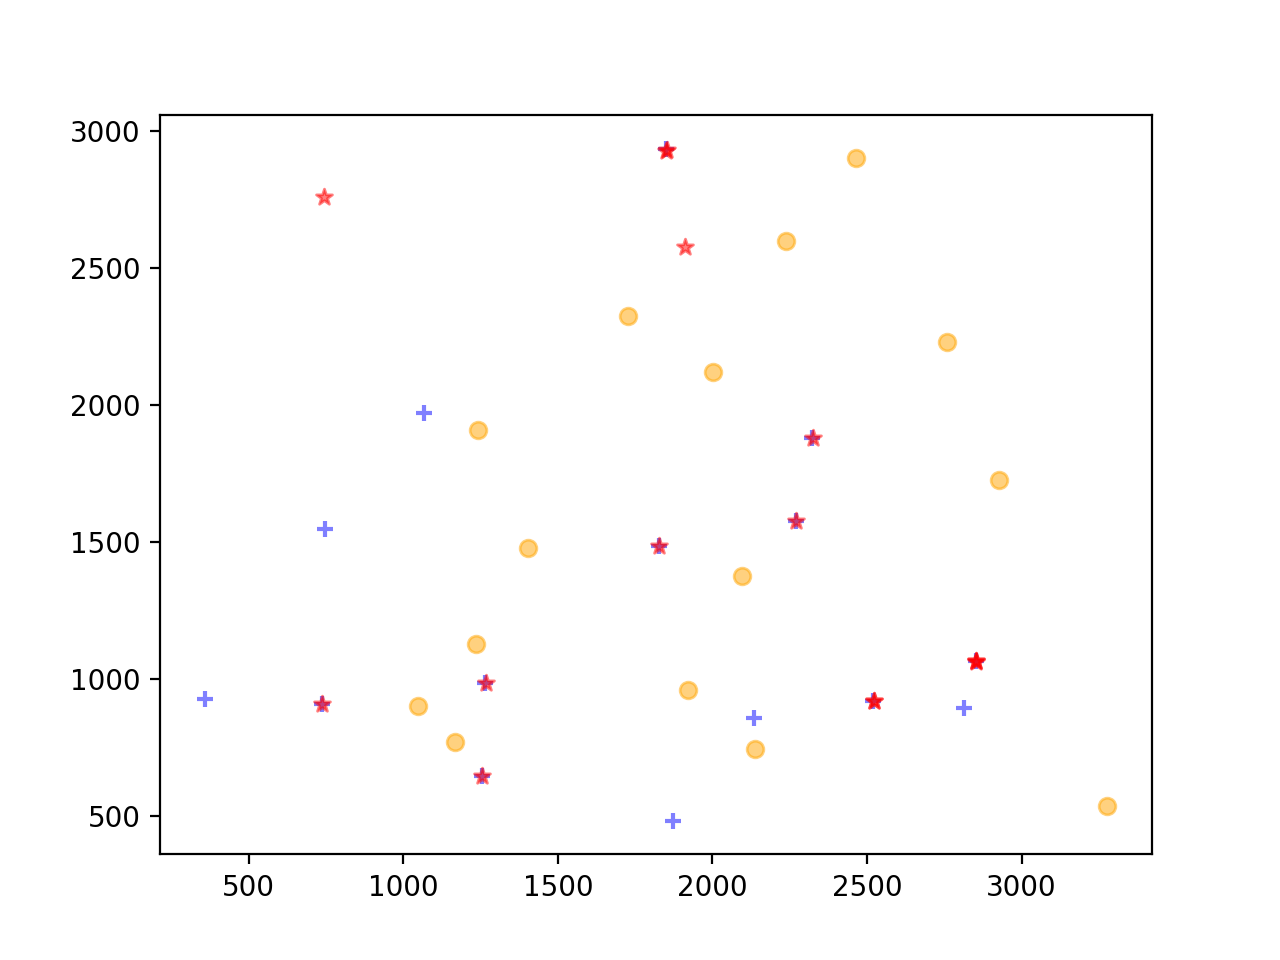

In [201]:
%matplotlib notebook
plt.scatter(t172x, t172y, marker='+', c='blue',alpha=0.5)
plt.scatter(t176x, t176y, marker='*', c='red',alpha=0.5)
plt.scatter(B2[0], B2[1], c='orange',alpha=0.5)

## Open CV Testing 
https://www.geeksforgeeks.org/image-registration-using-opencv-python/
https://docs.opencv.org/4.x/db/d61/group__reg.html
https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/

In [186]:
import cv2
import numpy as np

# Open the image files.
#img1_color = cv2.imread("align.jpg") # Image to be aligned.
#img2_color = cv2.imread("ref.jpg") # Reference image.

img1_color = fits.open('/home/bekah/glcat/astrometry/e21442/dose_files/e21442-nd-t0002-b00-f00007-g_dose.fits')
img2_color = fits.open('/home/bekah/glcat/astrometry/e21442/dose_files/e21442-nd-t0002-b00-f00008-g_dose.fits')

# Convert to grayscale.

img1 = img1_color[0].data
img2 = img2_color[0].data

from PIL import Image

img1_im = Image.fromarray(img1.astype(np.uint8)) 
img2_im = Image.fromarray(img2.astype(np.uint8)) 

#import scipy.misc
#img1_im = scipy.misc.toimage(img1)
#img2_im = scipy.misc.toimage(img2)


# Create ORB detector with 5000 features.
orb_detector = cv2.ORB_create(5000)

# Find keypoints and descriptors.
# The first arg is the image, second arg is the mask
# (which is not required in this case).
kp1, d1 = orb_detector.detectAndCompute(img1_im, None)
kp2, d2 = orb_detector.detectAndCompute(img2_im, None)

# Match features between the two images.
# We create a Brute Force matcher with
# Hamming distance as measurement mode.
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Match the two sets of descriptors.
matches = matcher.match(d1, d2)

# Sort matches on the basis of their Hamming distance.
matches.sort(key = lambda x: x.distance)

# Take the top 90 % matches forward.
matches = matches[:int(len(matches)*0.9)]
no_of_matches = len(matches)

# Define empty matrices of shape no_of_matches * 2.
p1 = np.zeros((no_of_matches, 2))
p2 = np.zeros((no_of_matches, 2))

for i in range(len(matches)):
    p1[i, :] = kp1[matches[i].queryIdx].pt
    p2[i, :] = kp2[matches[i].trainIdx].pt

# Find the homography matrix.
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

# Use this matrix to transform the
# colored image wrt the reference image.
transformed_img = cv2.warpPerspective(img1_color, homography, (width, height))

# Save the output.
cv2.imwrite('output.jpg', transformed_img)


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'detectAndCompute'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'


## image phase cross correlation 
https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_translation.html

<IPython.core.display.Javascript object>


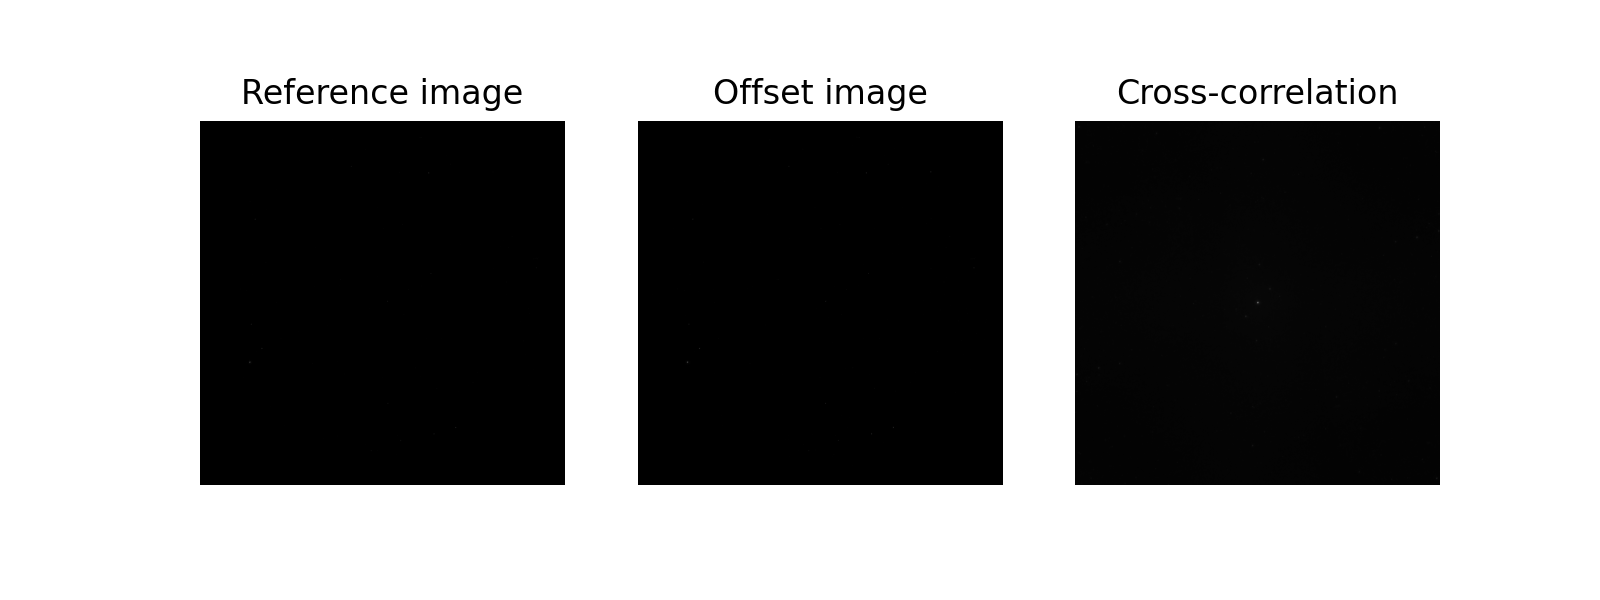

Detected pixel offset (y, x): [0. 3.]


<IPython.core.display.Javascript object>


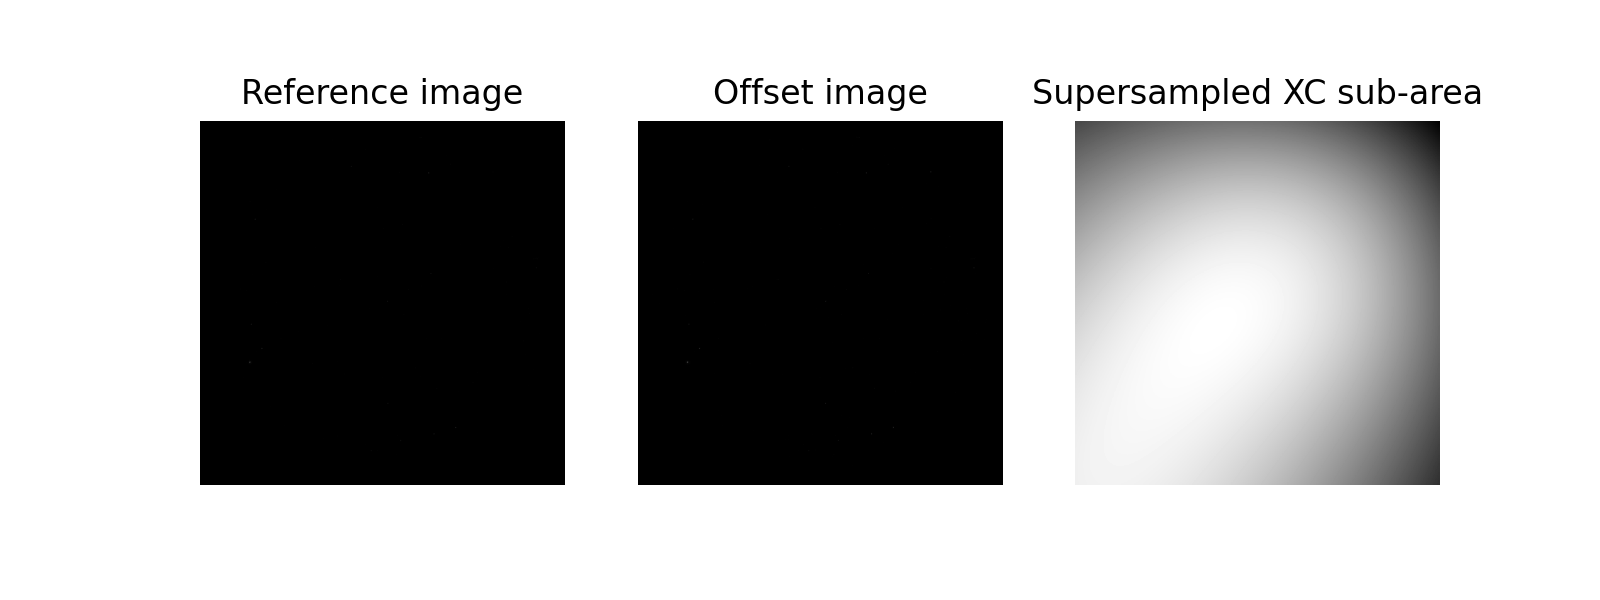

Detected subpixel offset (y, x): [0.74 2.58]


In [205]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

#image = data.camera()
#shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
#offset_image = fourier_shift(np.fft.fftn(image), shift)
#offset_image = np.fft.ifftn(offset_image)
#print(f'Known offset (y, x): {shift}')
%matplotlib notebook

img1_color = fits.open('/home/bekah/glcat/astrometry/e21442/dose_files/e21442-nd-t0002-b00-f00007-g_dose.fits')
img2_color = fits.open('/home/bekah/glcat/astrometry/e21442/dose_files/e21442-nd-t0002-b00-f00008-g_dose.fits')
image = img1_color[0].data
offset_image = img2_color[0].data


# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift}')

# subpixel precision
shift, error, diffphase = phase_cross_correlation(image, offset_image,
                                                  upsample_factor=100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print(f'Detected subpixel offset (y, x): {shift}')